### 并行版本

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
# 自定义函数
from import_fun import HH_model, Euler, RK4, spikes_eval
from import_fun import spikes_eval, record_spike_times, calculate_kuramoto
from import_fun import syn_chem_sigmoidal, create_sf
from import_fun import delay
from import_fun import cal_synFactor, return_synFactor

In [2]:
@njit
def net(N, method, dt, conn, tau):
    t = 0.
    
    axis=[0]    # 需要加上外部激励的维度

    # 创建节点
    N_vars = 4      # 变量的数量
    params_nodes = {
        'g_Na': 120.,     # 钠离子通道的最大电导(mS/cm2)
        'g_K': 36.,       # 钾离子通道的最大电导(mS/cm2)
        'g_L': 0.3,      # 漏离子电导(mS/cm2)
        'E_Na': 50.,      # 钠离子的平衡电位(mV)
        'E_K': -77.,      # 钾离子的平衡电位(mV)
        'E_L': -54.4,    # 漏离子的平衡电位(mV)
        'Cm': 1.,       # 比膜电容(uF/cm2)
        'Iex': 20.,       # 恒定的外部激励电流(uA/cm2)
        "temperature": 6.3,     # 标准温度(℃) 实验温度为6.3
    }
    
    # 模型变量的初始值
    v0 = np.random.uniform(-.3, .3, N)
    m0 = 1 * np.random.rand(N)
    h0 = 1 * np.random.rand(N)
    n0 = 1 * np.random.rand(N)
    vars_nodes = np.vstack((v0, m0, h0, n0))

    # 节点放电测量
    th_up = 0      # 放电阈上值
    th_down = -10  # 放电阈下值
    flag = np.zeros(N, dtype=np.int32)           # 模型放电标志(>0, 放电)
    flaglaunch = np.zeros(N, dtype=np.int32)     # 模型开始放电标志(==1, 放电刚刚开始)
    firingTime = np.zeros(N)                # 记录放电时间(上次放电)
    # 初始化峰值时间记录相关变量
    max_spikes = 1000                                 # 假设每个神经元最多记录 1000 次放电
    spike_times = np.full((N, max_spikes), np.nan)
    spike_counts = np.zeros(N, dtype=np.int32)   # 放电次数计数

    # 网络参数和变量
    params_syn = {
        "e": 0.,     # 化学突触的平衡电位(mV)
        "theta": 0., # 放电阈值
        "epsi": 7.,  # 放电下滑斜率
    }
    w = 0.1 * np.ones((N, N))

    # 延迟参量
    delayN = int(tau/dt)             # 延迟时长
    k = 0                            # 指针位置
    delay_list = np.zeros((N, delayN+1))      # 延迟存储矩阵

    # 同步因子计算
    count = 0  # 统计计算次数
    # 初始化累加器
    up1 = 0.
    up2 = 0.
    down1 = np.zeros(N)
    down2 = np.zeros(N)


    # 初始换节点
    for _ in range(100_00):
        I = np.zeros((N_vars, N))    
        params_list = list(params_nodes.values())
        method(HH_model, vars_nodes, t, dt, I, params_list)

        spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)  # 放电测算

        t += dt

    # 初始化网络
    for _ in range(500_00):
        # 突触
            # 触前和突触后的状态
        pre_mem, k = delay(vars_nodes[0], k, delayN, delay_list)
        pre_state = [pre_mem, firingTime, flaglaunch.astype(np.float64)]
        post_state = [vars_nodes[0], firingTime, flaglaunch.astype(np.float64)]
        params_list = list(params_syn.values())
        I_post = syn_chem_sigmoidal(pre_state, post_state, w, conn, params_list)  # 突触后神经元接收的突触电流
        
        # 节点
        I = np.zeros((N_vars, N))
        # 更新 I 数组
        for i in axis:
            I[i, :] += I_post
        params_list = list(params_nodes.values())
        method(HH_model, vars_nodes, t, dt, I, params_list)

        spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)  # 放电测算

        t += dt

    # mem = []
    # time = []
    cal_Tn = 2000_00
    for _ in range(cal_Tn):
        # 突触
            # 触前和突触后的状态
        pre_mem, k = delay(vars_nodes[0], k, delayN, delay_list)
        pre_state = [pre_mem, firingTime, flaglaunch.astype(np.float64)]
        post_state = [vars_nodes[0], firingTime, flaglaunch.astype(np.float64)]
        params_list = list(params_syn.values())
        I_post = syn_chem_sigmoidal(pre_state, post_state, w, conn, params_list)  # 突触后神经元接收的突触电流
        
        # 节点
        I = np.zeros((N_vars, N))
        # 更新 I 数组
        for i in axis:
            I[i, :] += I_post
        params_list = list(params_nodes.values())
        method(HH_model, vars_nodes, t, dt, I, params_list)

        spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)  # 放电测算

        # 记录峰值时间
        record_spike_times(flaglaunch, t, spike_times, spike_counts, max_spikes)

        t += dt

        up1, up2, count = cal_synFactor(vars_nodes[0], up1, up2, down1, down2, count, cal_Tn)

        # mem.append(vars_nodes[0].copy())
        # time.append(t)

    SFactor = return_synFactor(up1, up2, down1, down2, count, cal_Tn)

    kop = calculate_kuramoto(spike_times, dt, min_spikes=10)[0]

    return SFactor, kop

In [3]:
@njit(parallel=True)
def parallel_SFactor(tau_list, N, method, dt, conn):
    n = len(tau_list)
    SFactors = np.zeros(n)
    kops = np.zeros(n) 
    for i in prange(n):
        tau = tau_list[i]
        SFactors[i], kops[i] = net(N, method, dt, conn, tau)

    return SFactors, kops

In [4]:
dt = 0.01
method = Euler    # （"euler", "rk4"）
N = 100
# tau = 36
conn = create_sf(n=N, n_init=5, n_add=2)
tau_list = np.arange(0.01, 30, .5)

In [5]:
# SFactor = net(N, method, dt, conn, tau)
# SFactor

In [6]:
SFactors, kops = parallel_SFactor(tau_list, N, method, dt, conn)

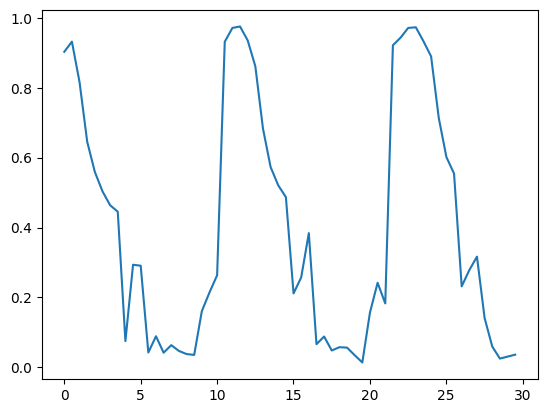

In [7]:
plt.plot(tau_list, SFactors)
plt.show()

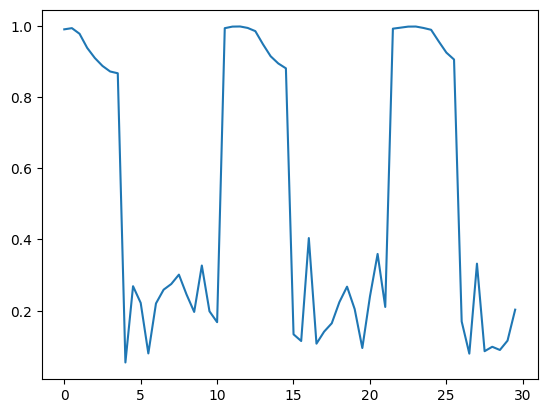

In [9]:
plt.plot(tau_list, kops)
plt.show()

In [8]:
# plt.plot(time, mem)
# plt.show()